<a href="https://colab.research.google.com/github/matheusrbg/Reconhecimento-do-Alfabeto-em-Libras/blob/main/vgg19bn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
import time
import os
import copy
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
use_gpu = torch.cuda.is_available()
use_gpu

True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !unzip -n /content/drive/MyDrive/LIBRAS/test.zip -d /content/drive/MyDrive/LIBRAS/ 

# Preprocessing

In [ ]:
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
        #transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15),
        transforms.RandomPerspective(0.3),
        transforms.RandomInvert(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [ ]:
data_dir = "drive/MyDrive/LIBRAS"
num_workers = 2

image_datasets = {
    'train': datasets.ImageFolder(
        root=os.path.join(data_dir, 'train'), 
        transform=transform
    ),
    'val': datasets.ImageFolder(
        root=os.path.join(data_dir, 'test'), 
        transform=transform_test
    ),
    'test': datasets.ImageFolder(
        root=os.path.join(data_dir, 'test'), 
        transform=transform_test
    )
}
dataloaders = {
    'train': torch.utils.data.DataLoader(
        image_datasets['train'], batch_size=64,
        shuffle=True, num_workers=num_workers
    ),
    'val': torch.utils.data.DataLoader(
        image_datasets['test'], batch_size=32,
        shuffle=True, num_workers=num_workers
    ),
    'test': torch.utils.data.DataLoader(
        image_datasets['test'], batch_size=32,
        shuffle=True, num_workers=num_workers
    )
}
pathloaders = {
    'train': torch.utils.data.DataLoader(
        image_datasets['train'].imgs, batch_size=64,
        shuffle=True, num_workers=num_workers
    ),
    'val': torch.utils.data.DataLoader(
        image_datasets['test'].imgs, batch_size=32,
        shuffle=True, num_workers=num_workers
    ),
    'test': torch.utils.data.DataLoader(
        image_datasets['test'].imgs, batch_size=32,
        shuffle=True, num_workers=num_workers
    ),
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test', 'val']}

In [ ]:
for x in ['train', 'test', 'val']:
    print("Loaded {} images in {}".format(dataset_sizes[x], x))
    
print("Classes: ")

label = image_datasets['test'].classes
print(image_datasets['train'].classes)
print(label)

Loaded 34714 images in train
Loaded 5783 images in test
Loaded 5783 images in val
Classes: 
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y']
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y']


# Creating Model

In [ ]:
num_classes = len(os.listdir(data_dir + '/train'))
num_epochs = 5
batch_size = 64
learning_rate = 0.0005

model = torchvision.models.vgg19_bn(weights="IMAGENET1K_V1")

if use_gpu:
  model.to(device)

# Newly created modules have require_grad=True by default
num_features = model.classifier[6].in_features
features = list(model.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, num_classes)]) # Add our layer with 4 outputs
model.classifier = nn.Sequential(*features) # Replace the model classifier

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  

# Training

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=5):
    if use_gpu:
        with torch.no_grad():
            model = model.to(device)

    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders['train'])
    
    loss_values = []
    acc_values = []
    for epoch in tqdm(range(num_epochs)):
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        
        model.train(True)
        pbar = tqdm(total=train_batches)
        for i, data in enumerate(dataloaders['train']):
            pbar.update(1)
                            
            inputs, labels= data
            
            if use_gpu:
                with torch.no_grad():
                    inputs, labels = inputs.cuda(), labels.cuda()
            else:
                with torch.no_grad():
                    inputs, labels = inputs, labels
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()

        avg_loss = loss_train  / dataset_sizes['train']
        avg_acc = acc_train  / dataset_sizes['train']
        loss_values.append((avg_loss, avg_loss_val))
        acc_values.append((avg_acc, avg_acc_val))
        model.train(False)
        model.eval()

        print("Running validation")
        y_true = []
        y_pred = []
        avg_loss_val = 0
        avg_acc_val = 0
        loss_test = 0
        acc_test = 0
        pbar = tqdm(total=len(dataloaders['val']))
        for i, data in enumerate(dataloaders['val']):
          pbar.update(1)
          
          inputs, labels = data
          
          y_true = y_true + labels.tolist()
          if use_gpu:
              with torch.no_grad():
                  inputs, labels = inputs.cuda(), labels.cuda()
          else:
              with torch.no_grad():
                  inputs, labels = inputs, labels
          
          outputs = model(inputs)

          _, preds = torch.max(outputs.data, 1)
          loss = criterion(outputs, labels)
          #print(preds)
          y_pred = y_pred + preds.tolist()
          
          loss_test += loss.item()
          acc_test += torch.sum(preds == labels.data)

          del inputs, labels, outputs, preds
          torch.cuda.empty_cache()

        avg_loss_val = loss_test / dataset_sizes['val']
        avg_acc_val = acc_test / dataset_sizes['val']
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (validation): {:.4f}".format(avg_loss_val))
        print("Avg acc (validation): {:.4f}".format(avg_acc_val))
        
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))

        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(model.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model,acc_values,loss_values

In [ ]:
model,acc,loss = train_model(model, criterion, optimizer, num_epochs=num_epochs)
torch.save(model.state_dict(),'VGG19_libras.pt')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0/4
----------


  0%|          | 0/543 [00:00<?, ?it/s]

Running validation


  0%|          | 0/181 [00:00<?, ?it/s]


Epoch 0 result: 
Avg loss (validation): 0.0002
Avg acc (validation): 0.9995
Avg loss (train): 0.0092
Avg acc (train): 0.8433
----------

Epoch 1/4
----------


  0%|          | 0/543 [00:00<?, ?it/s]

Running validation


  0%|          | 0/181 [00:00<?, ?it/s]


Epoch 1 result: 
Avg loss (validation): 0.0001
Avg acc (validation): 1.0000
Avg loss (train): 0.0002
Avg acc (train): 0.9982
----------

Epoch 2/4
----------


  0%|          | 0/543 [00:00<?, ?it/s]

Running validation


  0%|          | 0/181 [00:00<?, ?it/s]


Epoch 2 result: 
Avg loss (validation): 0.0000
Avg acc (validation): 1.0000
Avg loss (train): 0.0001
Avg acc (train): 0.9993
----------

Epoch 3/4
----------


  0%|          | 0/543 [00:00<?, ?it/s]

Running validation


  0%|          | 0/181 [00:00<?, ?it/s]


Epoch 3 result: 
Avg loss (validation): 0.0000
Avg acc (validation): 1.0000
Avg loss (train): 0.0001
Avg acc (train): 0.9995
----------

Epoch 4/4
----------


  0%|          | 0/543 [00:00<?, ?it/s]

Running validation


  0%|          | 0/181 [00:00<?, ?it/s]


Epoch 4 result: 
Avg loss (validation): 0.0000
Avg acc (validation): 1.0000
Avg loss (train): 0.0001
Avg acc (train): 0.9997
----------


Training completed in 62m 57s
Best acc: 1.0000


Text(0.5, 1.0, 'VGG loss')

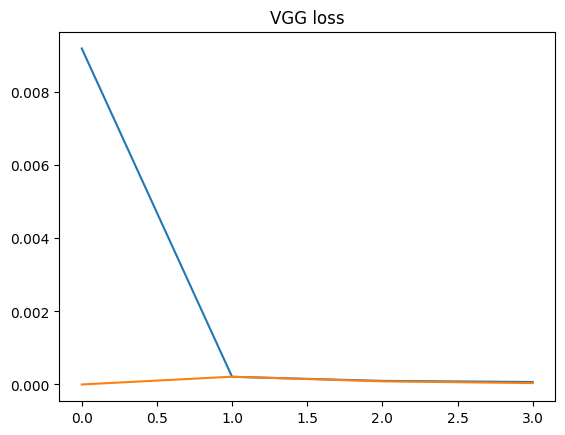

In [ ]:
plt.plot([it for it in loss[:-1]])
plt.title("VGG loss")

In [ ]:
!ls

drive  sample_data  VGG19_libras.pt


In [ ]:
!cp  VGG19_libras.pt drive/MyDrive/LIBRAS

# Evaluating

In [ ]:
PATH = "drive/MyDrive/LIBRAS/VGG19_libras.pt"
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
def eval_model(model, criterion):
    if use_gpu:
        with torch.no_grad():
            model = model.to(device)

    y_true = []
    y_pred = []
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders['test'])
    print("Evaluating model")
    print('-' * 10)
    pbar = tqdm(total=test_batches)
    for i, data in enumerate(dataloaders['test']):
        pbar.update(1)

        model.train(False)
        model.eval()
        
        inputs, labels = data
        
        y_true = y_true + labels.tolist()
        if use_gpu:
            with torch.no_grad():
                inputs, labels = inputs.cuda(), labels.cuda()
        else:
            with torch.no_grad():
                inputs, labels = inputs, labels
        
        outputs = model(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        #print(preds)
        y_pred = y_pred + preds.tolist()
        
        loss_test += loss.item()
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes['test']
    avg_acc = acc_test / dataset_sizes['test']
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [ ]:
criterion = nn.CrossEntropyLoss()
eval_model(model, criterion)

Evaluating model
----------


  0%|          | 0/181 [00:00<?, ?it/s]


Evaluation completed in 0m 45s
Avg loss (test): 0.0001
Avg acc (test): 1.0000
----------
